In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import BlackScholes as bs
import time
import variance_curve as vc
import ImpliedDrift as iD

from scipy.optimize import least_squares as ls
from rbergomi import rBergomi
from matplotlib import cm

In [2]:
def price(S, K, r, q, T):
    n = len(K)
    p = np.zeros(n)
    for i in range(n):
        p[i] = np.mean(np.maximum(S-K[i],0)*np.exp(-(r-q)*T))
    return p

In [3]:
spot = np.array(pd.read_csv("spot.csv").Spot)
index = 0
S0 = spot[index]

IV_df = pd.read_csv("hist_spx.csv")
moneyness = np.array([80.0,90.0,95.0,97.5,100.0,102.5,105.0,110.0,120.0])
maturities = np.array(IV_df['Exp Date']).flatten()
IV = np.array(IV_df.drop(columns = 'Exp Date'))/100.

K = moneyness*S0/100

In [4]:
start_time = time.time()
nr = len(maturities); nc = len(K);
rB_vol = np.zeros([nr,nc])
inp = np.array([0.1, 1.9, -0.9]) # Parameter array [H,eta,rho]
bnds = ([.0001, 1, -0.999],[.2, 7, -.8])
N = 20000; n = 365;
steps = np.ceil(n*maturities).astype(int)
T = maturities[-1]
np.random.seed(index)
    
def h(x):
    
    np.random.seed(index)
    t = time.time()
    
    iv = np.zeros([nr,nc])
    H, eta, rho = x
    alpha = H - 0.5
    
    rB = rBergomi(n, N, T, alpha)
    xi = vc.variance_curve(rB.t[0], index)
    dW1 = rB.dW1(); dW2 = rB.dW2();    
    Ya = rB.Y(dW1)
    dZ = rB.dZ(dW1, dW2, rho)
    V = rB.V(Ya, xi, eta)
    
    S = rB.global_S(V, dZ, S0, steps, index)
    
    for i in range(nr):
        aux_T = maturities[i]
        r = iD.r(aux_T, index); q = iD.q(aux_T, index);
        P = price(S[i,:], K, r, q, aux_T)
        iv[i,:] = bs.BSImpliedVol(S0, K, aux_T, r, q, P, Option_type = 1, toll = 1e-5)
    
    print(f'Function execution time: {time.time()-t: .0f} s')
    
    return iv

def f(x):
    return h(x).flatten() - IV.flatten()

result = ls(f, inp, bounds = bnds, max_nfev = 20, ftol = 1e-15, gtol = 1e-15, xtol = 1e-15)
rB_param = result.x   
rB_vol = h(result.x)

total_time = (time.time() - start_time)/60

print(f'\nTotal execution time: {total_time: .0f} minutes')

print(f"\nRelative mean error: {np.mean(abs(IV-rB_vol)/IV)*100:.4f}%")

Function execution time:  115 s
Function execution time:  118 s
Function execution time:  117 s
Function execution time:  108 s
Function execution time:  108 s
Function execution time:  115 s
Function execution time:  115 s
Function execution time:  115 s
Function execution time:  112 s
Function execution time:  115 s
Function execution time:  115 s
Function execution time:  112 s
Function execution time:  122 s
Function execution time:  113 s
Function execution time:  110 s
Function execution time:  124 s
Function execution time:  115 s
Function execution time:  124 s
Function execution time:  138 s
Function execution time:  118 s
Function execution time:  115 s
Function execution time:  114 s
Function execution time:  115 s
Function execution time:  118 s
Function execution time:  107 s
Function execution time:  120 s
Function execution time:  130 s
Function execution time:  119 s
Function execution time:  113 s
Function execution time:  110 s
Function execution time:  124 s
Function

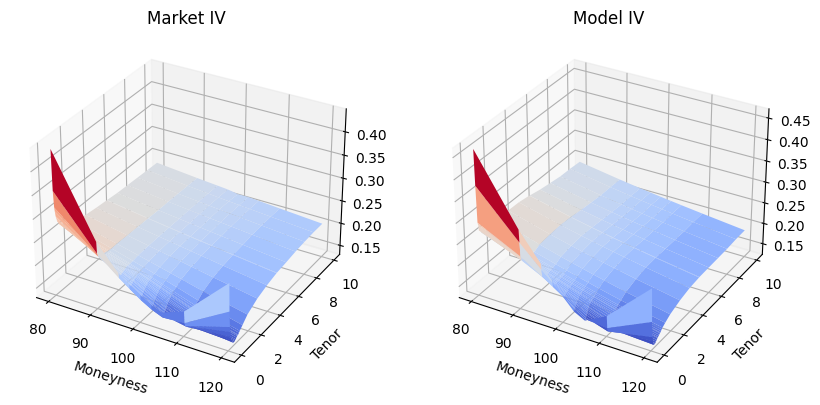

In [5]:
mesh_x, mesh_y = np.meshgrid(moneyness,maturities)

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(10)

ax1 = fig.add_subplot(121,projection='3d')
surf1 = ax1.plot_surface(mesh_x, mesh_y, IV, cmap=cm.coolwarm, antialiased=True)
ax1.set_xlabel('Moneyness')
ax1.set_ylabel('Tenor')
ax1.set_title('Market IV')

ax2 = fig.add_subplot(122,projection='3d')
surf2 = ax2.plot_surface(mesh_x, mesh_y, rB_vol, cmap=cm.coolwarm, antialiased=True)
ax2.set_xlabel('Moneyness')
ax2.set_ylabel('Tenor')
ax2.set_title('Model IV')

plt.show()

In [7]:
df = pd.DataFrame(rB_param.reshape((1,3)), columns = ["H", "eta", "rho"])
df.to_csv("rB_global_parameters.csv", index = False)

In [8]:
db = pd.DataFrame(rB_vol)
db.to_csv("rB_iv_global.csv", index = False)